# Windows of Opportunity: Increasing employee retention through candidate promotability and promotion window identification.

[Nikhil Gupta](guptan@mail.smu.edu), [Hayley Horn](hhorn@mail.smu.edu), [Max Moro](mmoro@email.smu.edu), [Michael Tieu](mtieu@mail.smu.edu)

## Table of Contents <a class="anchor" id="TOC"></a><br>

<font size = 4>[Business Purpose](#Section1)</font>

<font size = 4>[Data Preparation for Modeling](#Section2) </font> <br>
* [Basic Setup](#DP_Setup)<br>
* [Loading Functions](#DP_Loading)<br>
* [Data Processing](#DP_DP)<br>
* [Training and Testing Split](#DP_Split)<br>

<font size = 4>[Logistic Regression Model](#Section3) </font><br>
* [Scaling](#LRM_Scaling)<br>
* [Model](#LRM_Model)<br>
* [Parameter Adjustments](#LRM_PA)<br>
* [Final Model](#LRM_FinalM)<br>

<font size = 4>[Support Vector Machine Model](#Section4)</font><br>
* [Scaling](#SVM_Scaling)<br>
* [Model](#SVM_Model)<br>
* [Parameter Adjustments](#SVM_PA)<br>
* [Max Iterations Parameter Adjustment](#SVM_MaxIter)<br>
* [Adjusting Alpha Parameter](#SVM_Alpha)<br>
* [Final Model](#SVM_Final)<br>

<font size = 4>[Model Comparison](#Section5)</font><br>

<font size = 4>[Weights from Logistic Regression](#Section6)</font><br>
* [Theme 1 - Performance](#LRM_T1) <br>
* [Theme 2 - Supervision Status](#LRM_T2) <br>
* [Theme 3 - Regional](#LRM_T3) <br>
* [Theme 4 - Manager](#LRM_T4) <br>
* [Theme 5 - Functional Area](#LRM_T5)<br>
* [Theme 6 - Job Grade](#LRM_T6) <br>
* [Theme 7 - Tenure](#LRM_T7) <br>
* [Theme 8 - Education](#LRM_T8) <br>

<font size = 4>[Weights from Support Vectors](#Section7)</font><br>
* [Theme 1 - Performance](#SV_T1) <br>
* [Theme 2 - Supervision Status](#SV_T2)<br>
* [Theme 3 - Regional](#SV_T3) <br>
* [Theme 4 - Manager](#SVM_T4)<br>
* [Theme 5 - Functional Area](#SVM_T5)<br>
* [Theme 6 - Job Grade](#SVM_T6) <br>
* [Theme 7 - Tenure](#SVM_T7)<br>
* [Theme 8 - Education](#SVM_T8)<br>

<font size = 4>[Conclusion](#Section8) </font><br>

<font size = 4>[Appendix](#Section9) </font><br>
* [Model Comparison Table](#App_Table)

# <font color=maroon>Business Purpose</font><a class="anchor" id="Section1"></a>
As part of a larger study on improving employee retention, this analysis uses logistic regression and support vector machine models to identify employees with promotion potential. The data used has been prepared and cleaned prior to this analysis, though some additional steps were taken to optimize the data for modeling. There are two models that we have chosen to classify the data, and we will use consistent metrics to compare their classification efficacy. For this business case, it is preferable to overidentify potential candidates for promotion, rather than underpredict, so we will use recall for the promoted class level as the primary metric. The ultimate goal is to capture 75% of the promoted population. However, we do not want to have a model that will predict everyone getting promoted. In order to do so, we need to take precision into account along with recall. The best way to do this is to use the weighted F1 score. The weighted F1 score is the geometric mean of precision and recall. The goal here is to achieve a weighted F1 score of 0.75. The data set is large and global, so processing time will be taken into consideration. Any features used should make sense and be interpretable to business users.

[Back to Table of Contents](#TOC)

# <font color=maroon>Data Preparation for Modeling</font><a class="anchor" id="Section2"></a>
### <i>Basic Setup</i><a class="anchor" id="DP_Setup"></a>

The basic setup for this project requires loading Python libraries and setting up logging for this notebook. We enabled logging throughout the notebook to help the debug process and interpretability of the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import logging
import math
import statistics

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score, make_scorer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score, make_scorer

# For Time Logging
import time
from contextlib import contextmanager

In [2]:
%matplotlib inline
## Setup plot and logger
logging.getLogger().setLevel(logging.INFO)
plt.style.use('ggplot')

In [3]:
@contextmanager
# Timing Function
def time_usage(name=""):
    """
    log the time usage in a code block
    """
    #print ("In time_usage runID = {}".format(runID))
    start = time.time()
    yield
    end = time.time()
    elapsed_seconds = float("%.10f" % (end - start))
    logging.info('%s: Time Taken (seconds): %s', name, elapsed_seconds)

### <i>Loading Functions</i><a class="anchor" id="DP_Loading"></a>
These functions define repeatable processes used in this notebook. 

In [4]:
##################################### 
#### Grid Search Hyperparameters ####
#####################################
def plot_hyper_validation_curve2(estimator, X, y, param_name, param_range
                                ,title = "Validation Curve", xlabel = None, legend_loc='best', logX=False
                                ,cv=None,scoring="accuracy",n_jobs=None,verbose=0, ax = None):
    """
    * Recommended for use over plot_hyper_validation_curve
    * Adapted from: 
        - https://chrisalbon.com/machine_learning/model_evaluation/plot_the_validation_curve/
        - https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py
    * Differences from plot_hyper_validation_curve
        - Takes an ax argument so it can be used with subplots to plot everything in one window using matplotlib subplots
          Hence it gives a cleaner look
    """
      
    # Calculate accuracy on training and test set using range of parameter values
    train_scores, test_scores = validation_curve(estimator=estimator 
                                                 ,X=X,y=y 
                                                 ,param_name=param_name 
                                                 ,param_range=param_range
                                                 ,cv=cv 
                                                 ,scoring=scoring
                                                 ,verbose=verbose
                                                 ,n_jobs=n_jobs
                                                )
    

    # Calculate mean and standard deviation for training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    # Clean up for log X axis plotting
    x_label_append = "" # empty if not log scale
    if (logX == True):
        param_range = np.log10(param_range)
        x_label_append = " (log scale)"
    
    # Plot mean accuracy scores for training and test sets
    ax.plot(param_range, train_mean, label="Training Score", color="r")
    ax.plot(param_range, test_mean, label="Cross-Validation Score", color="g")

    # Plot accurancy bands for training and test sets
    ax.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="r",alpha=0.1)
    ax.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="g",alpha=0.1)

    # Add annotations 
    ax.title.set_text(title)
    ax.set_ylabel((scoring + " Score").title())
    if xlabel == None:
        ax.set_xlabel("Hyperparameter: " + param_name + x_label_append)
    else:
        ax.set_xlabel(xlabel + x_label_append)
    
    ax.legend(loc=legend_loc)

def plot_hyper_validation_curves2(estimator, X, y, param_grid, scoring
                                  ,logX=False
                                  ,cv=None, refit = 'Accuracy'
                                  ,n_jobs=None,verbose=0,arFigsize=None ):
    
    """
    # * Adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
    # * Fits only 1 time and gets all the metrics at once. Hence faster if evaluating many metrics at once 
        (even though GridSearchCV is not as efficient as validation_curve)
    """
    
    gs = GridSearchCV(estimator = estimator
                      ,param_grid=param_grid
                      ,scoring=scoring, cv=cv, refit=refit
                      ,return_train_score=True,n_jobs=-1,verbose=verbose)
    gs.fit(X, y)
    results = gs.cv_results_ 
    
    # Plotting the result
    
    num_rows = math.ceil(len(scoring)/2)
    if (arFigsize == None):
        arFigsize = (12,num_rows*4)
    fig, axes = plt.subplots(num_rows, 2, figsize=arFigsize,squeeze =False)
       
    # For this function, we only expect 1 key
    # If you have more than 1 parameter for GC, then results may not be as expected
    for hyper in param_grid:
        # Get the regular numpy array from the MaskedArray
        X_axis = np.array(results['param_' + hyper].data, dtype=float)    
        
        x_label_append = " "
        if (logX == True):
            X_axis = np.log10(X_axis)
            x_label_append = " (log scale)"

        i = 0
        for scorer in scoring:
            title = "Validation Curve: " + scorer.title()
                       
            ax=axes[math.floor(i/2),i%2]
            for sample, style, color in (('train', 'o-', 'r'), ('test', 'o-', 'g')):
                sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
                sample_score_std = results['std_%s_%s' % (sample, scorer)]

                ax.plot(X_axis, sample_score_mean, style, color=color,
                        #alpha=1 if sample == 'test' else 1,
                        label="%s (%s)" % (scorer, sample))

                ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                                sample_score_mean + sample_score_std,
                                alpha=0.1 if sample == 'test' else 0.1, color=color)

                # Add annotations 
                ax.title.set_text(title)
                ax.set_ylim(-0.1, 1.1)
                ax.set_ylabel(scorer.title() + " Score")
                ax.set_xlabel("Hyperparameter: " + hyper + x_label_append)
                ax.grid()
                ax.legend(loc="best")

            best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
            best_score = results['mean_test_%s' % scorer][best_index]

            # Plot a dotted vertical line at the best score for that scorer marked by x
            ax.plot([X_axis[best_index], ] * 2, [0, best_score],
                    linestyle='-.', color='black', marker='x', markeredgewidth=3, ms=8)

            # Annotate the best score for that scorer
            ax.annotate("%0.2f" % best_score,
                        (X_axis[best_index], best_score + 0.005))


            i = i+1 # Increment for each scorer
    return(fig)    
    



In [5]:
#########################
#### Learning Curves ####
#########################

def plot_learning_curve2(estimator, title_suffix, X, y, scoring="accuracy", ylim=None, cv=None,
                         n_jobs=None, train_sizes=np.linspace(.2, 1.0, 5),verbose=1, ax = None):
    """
    * NOTE: Recommended for use over plot_learning_curve
    * Differences from plot_learning_curve
        - Takes an ax argument so it can be used with subplots to plot everything in one window using matplotlib subplots
          Hence it gives a cleaner look
          
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    
    
    train_sizes, train_scores, test_scores = learning_curve(estimator
                                                            ,X,y
                                                            ,cv=cv
                                                            ,scoring=scoring
                                                            ,n_jobs=n_jobs
                                                            ,train_sizes=train_sizes
                                                            ,verbose=verbose
                                                           )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    ## Annotate Plots
    ax.title.set_text("Learning Curve: " + title_suffix)
    if (ylim == None):
        ax.set_ylim(-0.1, 1.1)
    if ylim is not None:
        ax.set_ylim(*ylim)
       
    ax.set_ylabel(title_suffix + " Score")
    ax.set_xlabel("Training examples")
    ax.grid(b=True)
    ax.legend(loc="best")
    #return plt


def plot_learning_curves(estimator,X,y,scoring,cv=None,n_jobs=None,verbose=1,arFigsize=None):
    num_rows = math.ceil(len(scoring)/2)
    if (arFigsize == None):
        arFigsize = (12,num_rows*4)
    
    fig, axes = plt.subplots(num_rows, 2, figsize=arFigsize, squeeze=False)
    i = 0
    for scorer in scoring.keys():
        with time_usage(" Learning Curve | " + scorer):
            plot_learning_curve2(estimator=estimator
                                ,title_suffix  = scorer.title()
                                ,X=X, y=y
                                ,scoring=scoring[scorer]
                                ,cv=cv
                                ,n_jobs=n_jobs
                                ,verbose=verbose
                                ,ax=axes[math.floor(i/2),i%2]
                               )
            i = i+1

   #plt.show()

In [6]:
##########################
#### COMMON FUNCTIONS ####
##########################

def print_classification_details(actual,predicted):
    # print the accuracy and confusion matrix 
    cm = mt.confusion_matrix(actual,predicted)
    cr = mt.classification_report(actual,predicted)
    
    print("confusion matrix\n", cm)
    plot_classification_report(cr)
    
    
def plot_classification_report(cr, title=None, cmap='RdBu'):
    """
    Adapted from https://medium.com/district-data-labs/visual-diagnostics-for-more-informed-machine-learning-7ec92960c96b
    """
    title = title or 'Classification report'
    lines = cr.split('\n')
    classes = []
    matrix = []
  
    for line in lines[2:(len(lines)-5)]:
        s = line.split()
        classes.append(s[0])
        value = [float(x) for x in s[1: len(s) - 1]]
        matrix.append(value)

    fig, ax = plt.subplots(1)

    for column in range(len(matrix)+1):
        for row in range(len(classes)):
            txt = matrix[row][column]
            #ax.text(column,row,matrix[row][column],va='center',ha='center')
            ax.text(column,row,txt,va='center',ha='center',size="x-large",bbox=dict(facecolor='white', alpha=0.5))

    fig = plt.imshow(matrix, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(len(classes)+1)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['Precision', 'Recall', 'F1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.ylabel('Classes')
    plt.xlabel('Measures')
    plt.show()



In [7]:
######################
### SVM Functions ####
######################

def train_SVM(estimator,scl_obj,X,y,cv):
    """
    # Manual training of SVM using loops (does not parallelize)
    # Not recommended for detailed analysis (use Scikit Learn's internal functions with njobs for parallelism)
    # Only useful whe you want to visualize the confusion matrix and the classification report
    """
    for iter_num, (train_indices, test_indices) in enumerate(cv.split(X,y)):
        with time_usage(" SVM: Iteration " + str(iter_num+1)):
            X_train = X[train_indices]
            y_train = y[train_indices]

            X_test = X[test_indices]
            y_test = y[test_indices]

            scl_obj.fit(X_train) 
            X_train_scaled = scl_obj.transform(X_train) # apply to training
            X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

            estimator.fit(X_train_scaled,y_train)  # train object

            y_hat = estimator.predict(X_test_scaled) # get test set precitions
            print_classification_details(actual=y_test, predicted=y_hat)    
        

In [78]:
# move this section up to the functions
def plot_sv(theme,top=0,verbose=0,hist=False):
    #search for the vars to plot and calculate ratio betwene means
    vars_to_plot = pd.DataFrame(columns=['var','support','original','ratio'])
    for each in df_support.columns.tolist(): 
        #print(each)
        if each in theme:
            if(all(df_grouped_support[each].mean()!=0) &  all(df_grouped[each].mean()!=0) ):
                vars_to_plot=vars_to_plot.append({'var':each
                                     ,'support':df_grouped_support[each].mean()[1]
                                     ,'original':df_grouped[each].mean()[1]
                                     ,'ratio':0
                                    },ignore_index=True )
            
    vars_to_plot['ratio'] = abs((vars_to_plot['support'] - vars_to_plot['original'])/(vars_to_plot['original']))
    vars_to_plot = vars_to_plot.set_index('var')                                              
    #vars_to_plot = vars_to_plot[(vars_to_plot['support']!=0) & (vars_to_plot['original']!=0)]
    vars_to_plot = vars_to_plot.sort_values('ratio',ascending=False)
    if(verbose): print(vars_to_plot[0:10])
    if(top>0):
        vars_to_plot = vars_to_plot[0:top]
    
    num_rows=vars_to_plot.shape[0]
    arFigsize=(12,num_rows*4)
    img, axes = plt.subplots(num_rows, 2, figsize=arFigsize,squeeze =False)
    i=0
    n_equal_bins = 20 
    for v in vars_to_plot.index:
        if(verbose): print('.',end='')
        ax=axes[i,0]
        if(hist): 
            first_edge, last_edge = df_support[v].min(), df_support[v].max()
            bin_edges = np.linspace(start=first_edge, stop=last_edge,num=n_equal_bins + 1, endpoint=True)
            df_grouped_support[v].plot(kind='hist',ax=ax,alpha=0.5,bins=bin_edges) 
        else: df_grouped_support[v].plot.kde(ax=ax) 
        ax.legend(['Not Promoted','Promoted'])
        ax.title.set_text(v+'\n (Support Vectors)')
        ax=axes[i,1]
        if(hist): 
            first_edge, last_edge = df_imputed[v].min(), df_imputed[v].max()
            bin_edges = np.linspace(start=first_edge, stop=last_edge,num=n_equal_bins + 1, endpoint=True)
            df_grouped[v].plot(kind='hist',ax=ax,alpha=0.5,bins=bin_edges) 
        else: df_grouped[v].plot.kde(ax=ax) 
        ax.legend(['Not Promoted','Promoted'])
        ax.title.set_text(v+'\n (Original)')
        i = i+1
    #return(img)


### <i>Data Processing</i><a class="anchor" id="DP_DP"></a>
This section covers  adjustments to the data for the logistic and SVM models.

#### Read in data file

In [8]:
### Reading data 
df = pd.read_csv("../../data/data_for_classification.csv")

#### Managing Nulls
Nulls can cause errors for some models, depending on the quantity we will drop records with null values.

In [9]:
null_vals = df.isnull().sum(axis = 0)
print(null_vals[null_vals != 0])
df.dropna(inplace=True)

reporting_level_last                 14
accountability_matrix_label_last      3
functional_area_last                  3
job_family_label_last                 5
job_long_text_last                    6
operational_rollup_label_last       191
org_unit_desc_last                   44
dtype: int64


**Solution:** Dropping nulls as they comprise approximately <0.2% of the data

#### Review number of levels in categorical features
We will review the counts of the levels of categorical features with the SME and determine which ones can be removed. 

In [10]:
categorical_features = df.select_dtypes(include='object').columns
categorical_features

Index(['worker', 'accountability_matrix_label_last', 'company_code_last',
       'cost_center_code_last', 'functional_area_last', 'supervisor_last',
       'gjs_code_label_last', 'gjs_framework_last', 'job_family_label_last',
       'job_long_text_last', 'operational_rollup_label_last',
       'org_unit_desc_last', 'site_city_code_last', 'site_country_code_last',
       'site_country_region_last', 'site_country_segment_last',
       'site_desc_last', 'certificate_order_grp_last'],
      dtype='object')

In [11]:
for column in categorical_features:
    if column in df.columns:
        print ("The number of levels in column '{}': {}".format(column,df[column].nunique()))

The number of levels in column 'worker': 66927
The number of levels in column 'accountability_matrix_label_last': 29
The number of levels in column 'company_code_last': 50
The number of levels in column 'cost_center_code_last': 1943
The number of levels in column 'functional_area_last': 3
The number of levels in column 'supervisor_last': 9755
The number of levels in column 'gjs_code_label_last': 43
The number of levels in column 'gjs_framework_last': 9
The number of levels in column 'job_family_label_last': 199
The number of levels in column 'job_long_text_last': 1506
The number of levels in column 'operational_rollup_label_last': 162
The number of levels in column 'org_unit_desc_last': 8342
The number of levels in column 'site_city_code_last': 224
The number of levels in column 'site_country_code_last': 28
The number of levels in column 'site_country_region_last': 3
The number of levels in column 'site_country_segment_last': 11
The number of levels in column 'site_desc_last': 318
The 

**Solution:** 
- Drop 'supervisor_last' as we dont need the names (identifiers) of the last managers. 
- Drop 'site_city_code_last' as country is more meaningful than city and city anyway has more variation.
- Drop 'site_desc_last' as this refers to different buildings which will not impact promotion.
- Drop 'org_unit_desc_last' as accountability matrix is more meaningful than org_unit and org_unit anyway has more variation.
- Drop 'cost_center_code_last' as accountability matrix is more meaningful than cost_center and cost_center anyway has more variation.
- Drop 'job_long_text_last' as gjs and gjs_family are more meaningful than job_long_txt and job_long_txt anyway has too many variations.
- Drop 'Year Last','Month_num_last' and 'months_since_promotion_max' as they were determined to be highly correlated during initial data exploration project
- Drop 'worker' and 'unamed: 0' as these two fields are IDs of the Rows and therefor not predictors.
- Drop 'months_since_promtion_max', 'year_last', and  'month_num_last' they are cofounding with months_since_promotion_max and month columns, based on the exploration project
- Keep for now and analyze 'operational_rollup_label_last' (group of cost centers)
- Keep for now and analyze 'job_family_label_last' -- Group of Jobs


In [12]:
cols_to_del = ["supervisor_last"
               ,"org_unit_desc_last"
               ,"cost_center_code_last"
               ,"job_long_text_last"
               ,"site_city_code_last"
               ,"site_desc_last"  
               ,"year_last"
               ,"month_num_last"
               ,'months_since_promotion_max'
               ,"worker"
               ,"Unnamed: 0"
                ]
for column in df.columns:
    if column in cols_to_del:
        del df[column]

In [13]:
categorical_features = df.select_dtypes(include='object').columns
for column in categorical_features:
    if column in df.columns:
        print ("The number of levels in column '{}': {}".format(column,df[column].nunique()))

The number of levels in column 'accountability_matrix_label_last': 29
The number of levels in column 'company_code_last': 50
The number of levels in column 'functional_area_last': 3
The number of levels in column 'gjs_code_label_last': 43
The number of levels in column 'gjs_framework_last': 9
The number of levels in column 'job_family_label_last': 199
The number of levels in column 'operational_rollup_label_last': 162
The number of levels in column 'site_country_code_last': 28
The number of levels in column 'site_country_region_last': 3
The number of levels in column 'site_country_segment_last': 11
The number of levels in column 'certificate_order_grp_last': 14


#### Convert Categorial features into dummy variables
We will transform the levels of categorical features to dummy variables with binary values.

In [14]:
cat_with_dummies = pd.get_dummies(df[categorical_features])

#### Review Column Count

In [15]:
cat_with_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94108 entries, 0 to 94360
Columns: 551 entries, accountability_matrix_label_last_Agudath to certificate_order_grp_last_99-Not Indicated
dtypes: uint8(551)
memory usage: 50.2 MB


In [16]:
cat_with_dummies = pd.get_dummies(df[categorical_features],drop_first=True)

In [17]:
cat_with_dummies.shape

(94108, 540)

#### Drop Categorical features

In [18]:
df.drop(categorical_features,axis=1,inplace=True)

#### Replace with dummy variables

In [19]:
df = pd.concat([df,cat_with_dummies],axis=1)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94108 entries, 0 to 94360
Columns: 592 entries, promotion_cnt to certificate_order_grp_last_99-Not Indicated
dtypes: float64(8), int64(44), uint8(540)
memory usage: 86.5 MB


#### Save a copy of cleaned data

In [21]:
# Saving cleaned data for future use
# df.to_csv("../../data/MiniLab_Data.csv",index = False)

### <i>Training and Testing Split</i><a class="anchor" id="DP_Split"></a>
We will divide our data so that 80% is used for training and 20% is held out for testing. Additionally, we will use cross validation to separate our split data three times to provide additional opportunities to test our models and minimize the chance of overfitting.

In [22]:
# df = pd.read_csv("../../data/MiniLab_Data.csv")
# df.info()

#### Define the train/test split and prediction variable 
The variable used for prediction is 'promotion_max'

In [23]:
df_imputed = df.copy(deep=True)

# we want to predict the X and y data as follows:
if 'promotion_max' in df_imputed:
    y = df_imputed['promotion_max'].values # get the labels we want
    del df_imputed['promotion_max'] # get rid of the class label
    X = df_imputed.values # use everything else to predict!
 

#### Create cross validation object
We will do cross validation with 3 folds.  StratifiedShuffleSpilt was used because it preserves the percentage of samples in each class during the cross validation process.

In [24]:
num_cv_iterations = 3
num_instances = len(y)

cv_object = StratifiedShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2,
                         random_state = 101      
                        )
print(cv_object)

StratifiedShuffleSplit(n_splits=3, random_state=101, test_size=0.2,
            train_size=None)


[Back to Table of Contents](#TOC)

# <font color=maroon>Logistic Regression Model</font><a class="anchor" id="Section3"></a>


### <i>Scaling</i><a class="anchor" id="LRM_Scaling"></a>

Since we are going to use the models to compare the weights between the variables, we decided to scale the feature values to ensure a consistent comparison across the variables. 


In [25]:
std_scl = StandardScaler()


### <i>Model</i><a class="anchor" id="LRM_Model"></a>
Here we are setting up an initial logistic regression model. As the target variable has unbalanced factors, we decided to use the 'balanced' class_weight, otherwise the model will tend to predict all the outputs as not-promoted.

In [26]:
lr_clf = LogisticRegression(penalty='l2'
                            ,C=1.0
                            ,class_weight='balanced'
                            ,solver='liblinear'
                            ,n_jobs=1
                            ,random_state=101) 

confusion matrix
 [[9447 3937]
 [1304 4134]]


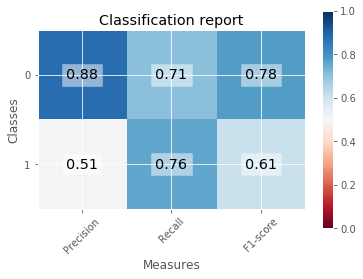

INFO:root: Logistic Regression: Iteration 1: Time Taken (seconds): 153.1693601608


confusion matrix
 [[9505 3879]
 [1306 4132]]


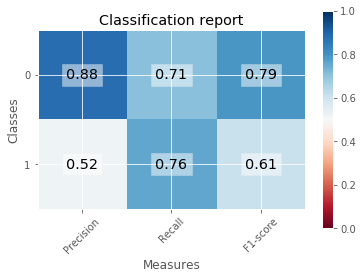

INFO:root: Logistic Regression: Iteration 2: Time Taken (seconds): 169.4412915707


confusion matrix
 [[9524 3860]
 [1323 4115]]


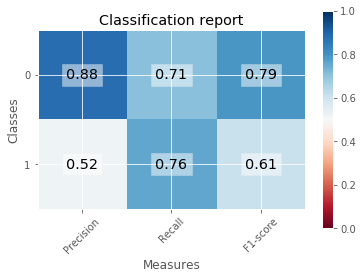

INFO:root: Logistic Regression: Iteration 3: Time Taken (seconds): 172.257999897


In [27]:
# 3 Fold Cross Validation using the CV object
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    with time_usage(" Logistic Regression: Iteration " + str(iter_num+1)):
        X_train = X[train_indices]
        y_train = y[train_indices]
    
        X_test = X[test_indices]
        y_test = y[test_indices]
        
        std_scl.fit(X_train) 
        X_train_scaled = std_scl.transform(X_train) # apply to training
        X_test_scaled = std_scl.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)
        
        lr_clf.fit(X_train_scaled,y_train)  # train object
    
        y_hat = lr_clf.predict(X_test_scaled) # get test set precitions
        print_classification_details(actual=y_test, predicted=y_hat)     
        

**Observation:**
The recall measure for the promoted class (0.76) is close to our objective (0.75). But the F1 score for the promoted class is 0.62, and this can pull down the balanced F1 score below our target of 0.75. Next, we try to adjust the parameters to see if we can get better measures.

### <i>Parameter Adjustments</i><a class="anchor" id="LRM_PA"></a>

We will adjust the regularization parameter C from 0.001 to 100 (log (sampled)), to see how this parameter will impact the performance of the model.


In [28]:
# Create range of values for parameter
c_values = [0.001,0.01,0.1,1,10,100]

# Create scorers to evaluate the models
scoring = {'Recall (Promoted Only)': make_scorer(recall_score, average='binary') # Positive Class Only
           ,'F1 (Weighted)': make_scorer(f1_score, average='weighted') # Weighted Score
          
}

std_scl = StandardScaler()

In [29]:

lr_clf = LogisticRegression(C=1 # we will change this to see the imapact
                            ,penalty='l2'
                            ,class_weight='balanced'
                            ,solver='liblinear'
                            ,n_jobs=-1
                            ,max_iter=1000
                            ,random_state=101
                            ,verbose=0
                           )

# Create a pipeline object to scale the data and then train a logistic regression model
piped_object = Pipeline([('scale', std_scl)  # do this
                         ,('logit_model', lr_clf)]) # and then do this

C:\Users\mmoro\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 32.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
INFO:root: Logistic Regression: Validation Curve: Time Taken (seconds): 349.7839999199


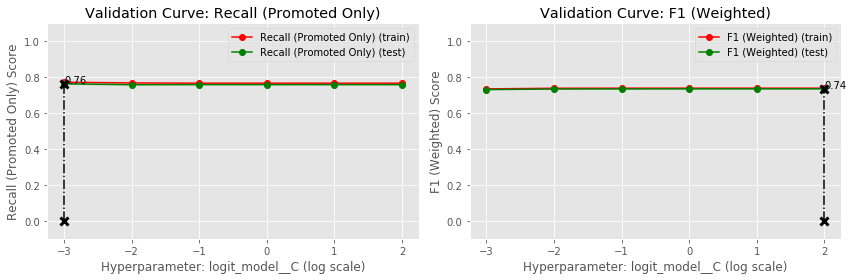

In [30]:
with time_usage(" Logistic Regression: Validation Curve"):
    plot_hyper_validation_curves2(estimator=piped_object
                                  ,X=X, y=y 
                                  ,param_grid={'logit_model__C': c_values}
                                  ,scoring = scoring
                                  ,logX=True
                                  ,cv=cv_object, refit = 'Recall (Promoted Only)'
                                  ,n_jobs=-1,verbose=0)
    
plt.tight_layout()

**Observation:** There is not significant impact on the recall and F1 scores by using different regularization hyperparameters C. Smaller values of C are expected to reduce overfitting. In our case, we have many data points and not so many attributes (features) so overfitting was not expected and we can see the same from the above chart.

**Conclusion: Pick C=0.1**

### <i>Final Model</i><a class="anchor" id="LRM_Final"></a><br>

In [31]:
# All parameters finalized
lr_clf = LogisticRegression(C=0.1 
                            ,penalty='l2'
                            ,class_weight='balanced'
                            ,solver='liblinear'
                            ,n_jobs=-1
                            ,max_iter=1000
                            ,random_state=101
                            ,verbose=0
                           )

piped_object = Pipeline([('scale', std_scl),  # do this
                         ('logit_model', lr_clf)]) # and then do this

**Observation:**
* From the above analysis, we see that there does not seem to be overfitting in the model (as the regularization factor does not seem to have any impact). 
* We will visualize this further by using the learning curves. These curves create multiple models with different training set sizes. 
* For smaller sizes of training sets, we expect the training error to be lower (evaluation metrics to be higher), and the test error to be higher (evaluation metrics to be lower) due to overfitting.
* As the training set size increases, the test and train metrics (error) should converge to be closer to each other. This essentially means that the model will be able to generalize well with no risk of overfitting.

[learning_curve] Training set sizes: [15057 30114 45171 60228 75286]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.9min finished
INFO:root: Learning Curve | Recall (Promoted Only): Time Taken (seconds): 113.376999855


[learning_curve] Training set sizes: [15057 30114 45171 60228 75286]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.9min finished
INFO:root: Learning Curve | F1 (Weighted): Time Taken (seconds): 115.8180000782


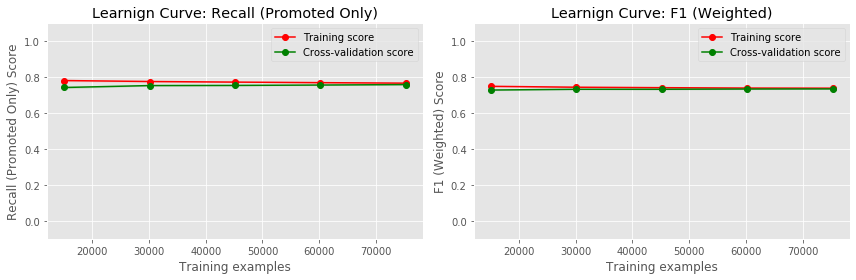

In [32]:
 plot_learning_curves(estimator=piped_object
                      ,X=X, y=y
                      ,scoring=scoring
                      ,cv=cv_object
                      ,n_jobs=-1
                      ,verbose=1
                   )

plt.tight_layout()

**Observation:**
* From the above plots, we see that the train and test metrics converge towards each other even for a much smaller training size of only ~15,000 observations. 
* At ~75,000 observations in the training set, there is virtually no difference in the metrics between the training and the cross-validation sets.

**Conclusion:** Hence, we conclude that the model we have created will generalize well to unknown observations and can be used in the future to predict (with similar precision and recall) employee promotability. 

[Back to Table of Contents](#TOC)

# <font color=maroon>Support Vector Machine Model</font><a class="anchor" id="Section4"></a>

### <i>Scaling</i><a class="anchor" id="SVM_Scaling"></a>
Gradient descent based optimization approaches tend to work better when the features are on the same range. Since our features have very different ranges we will scale all the features to a mean of zero with a standard deviation of one.

In [33]:
std_scl = StandardScaler()

### <i>Model</i><a class="anchor" id="SVM_Model"></a>
Our initial support vector machine model is run using an SGD classifier which balances the power of a support vector machines supervised learning with enhanced performance using the scaled gradient descent. The StratifiedShuffleSpilt was used because it preserves the percentage of samples in each class during the cross validation process.


In [34]:
cv_object = StratifiedShuffleSplit( n_splits=3,test_size=0.2, random_state = 101 )

In [35]:
# use some compact notation for creating a linear SVM classifier with stichastic descent
regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const
                        ,class_weight='balanced'
                        ,fit_intercept=True
                        ,l1_ratio=0.0
                        ,learning_rate='optimal'
                        ,loss='hinge'
                        ,n_iter_no_change=iterations
                        ,n_jobs=-1
                        ,penalty='l2'
                        ,random_state=101
                       )

scl_obj = StandardScaler()


confusion matrix
 [[8939 4445]
 [1189 4249]]


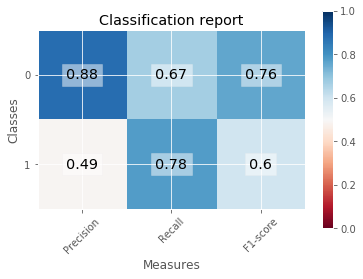

INFO:root: SVM: Iteration 1: Time Taken (seconds): 8.3370001316


confusion matrix
 [[8972 4412]
 [1216 4222]]


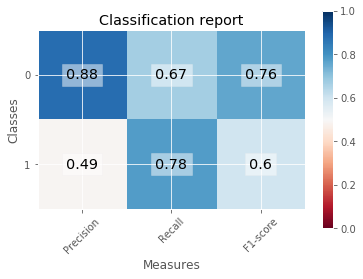

INFO:root: SVM: Iteration 2: Time Taken (seconds): 8.2610001564


confusion matrix
 [[9026 4358]
 [1211 4227]]


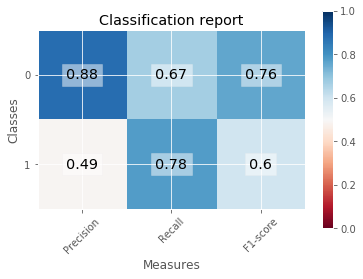

INFO:root: SVM: Iteration 3: Time Taken (seconds): 8.7660000324


In [36]:
train_SVM(estimator=svm_sgd, scl_obj=scl_obj, X=X, y=y, cv=cv_object)

**Observation:** The recall measure for the promoted class (0.78) is close to our objective (0.75), but the F1 score for the promoted class is 0.61. This can pull down the balanced F1 score below our target of 0.75. Next, we try to adjust the parameters to see if we can get better measures.

### <i>Parameter Adjustments</i><a class="anchor" id="SVM_PA"></a>


We are going to adjust the **max_iters** and **alpha** parameters to find the best option for the model, based on the recall and F1 measures.

In [37]:

# Create range of values for parameter to vary for Grid Search
max_iters = [10,50,100,500,1000,5000,10000]
alpha = [1e-12, 1e-11, 1e-10, 1e-9, 1e-8,1e-7, 1e-6, 1e-5,1e-4,1e-3,1e-2,1e-1,1]

# Object to scale the inputs before training
std_scl = StandardScaler()


### <i>Adjusting Max Iterations Parameter</i><a class="anchor" id="SVM_MaxIter"></a>

Here we adjust the maximum number of iterations to see how the different iteration values affect the algorithm and impact the metrics. This will help optimize training time for the rest of the analysis.

In [38]:
svm_sgd = SGDClassifier(alpha=regularize_const
                        ,class_weight='balanced'
                        ,fit_intercept=True
                        ,l1_ratio=0.0
                        ,learning_rate='optimal'
                        ,loss='hinge'
                        ,max_iter=1000
                        ,n_iter_no_change=5
                        ,n_jobs=-1
                        ,penalty='l2'
                        ,verbose=0
                        ,random_state=101
                       )

piped_object = Pipeline([('scale', std_scl),  # do this
                         ('svm_model', svm_sgd)]) # and then do this

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  21 | elapsed:   14.0s remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   19.5s finished
C:\Users\mmoro\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
INFO:root: SVM: Validation Curves | Regularization: Time Taken (seconds): 28.2300000191


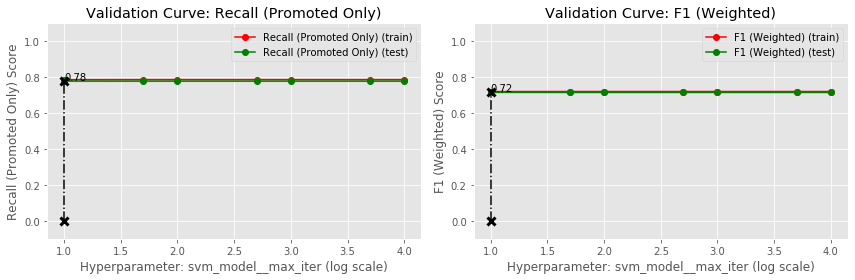

In [39]:
with time_usage(" SVM: Validation Curves | Regularization"):
    plot_hyper_validation_curves2(estimator=piped_object
                                  ,X=X, y=y 
                                  ,param_grid={'svm_model__max_iter': max_iters}
                                  ,scoring = scoring
                                  ,logX=True
                                  ,cv=cv_object, refit = 'Recall (Promoted Only)'
                                  ,n_jobs=-1,verbose=1) 

plt.tight_layout()

**Observation:** Max iterations shows no impact on the recall or F1 scores. Hence, we will pick the value of 1000 for the final model.

### <i>Adjusting Alpha Parameter</i><a class="anchor" id="LRM_Alpha"></a>

Here we adjust the alpha parameter used for regularization to see how the different values affect the algorithm and impact the metrics.

In [40]:
svm_sgd = SGDClassifier(alpha=0.1
                        ,class_weight='balanced'
                        ,fit_intercept=True
                        ,l1_ratio=0.0
                        ,learning_rate='optimal'
                        ,eta0=0.1
                        ,loss='hinge'
                        ,max_iter=1000
                        ,n_iter_no_change=5
                        ,n_jobs=-1
                        ,penalty='l2'
                        ,verbose=0
                        ,random_state=101
                       )

piped_object = Pipeline([('scale', std_scl),  # do this
                         ('svm_model', svm_sgd)]) # and then do this

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  39 | elapsed:   26.8s remaining:   38.6s
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:  1.2min finished
INFO:root: SVM: Validation Curves | Regularization with Adaptive Learning Rate: Time Taken (seconds): 82.7469997406


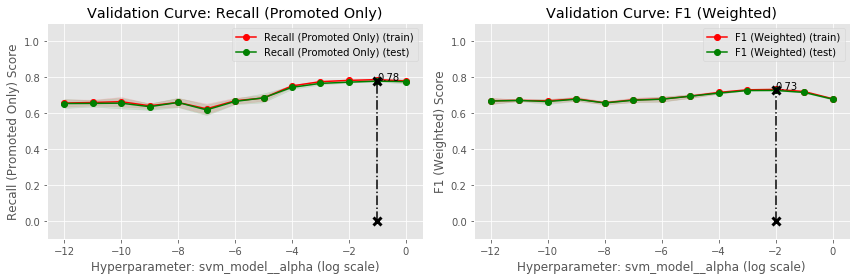

In [41]:
with time_usage(" SVM: Validation Curves | Regularization with Adaptive Learning Rate"):
    plot_hyper_validation_curves2(estimator=piped_object
                                  ,X=X, y=y 
                                  ,param_grid={'svm_model__alpha': alpha}
                                  ,scoring = scoring
                                  ,logX=True
                                  ,cv=cv_object, refit = 'Recall (Promoted Only)'
                                  ,n_jobs=-1,verbose=1) 

plt.tight_layout()

**Observation:** The charts show the impact of the alpha parameter on both recall and F1 measures; the alpha value of 1e-2 has the best tradeoff between recall 0.77 and weighted F1 score 0.73.

### <i>Final model</i><a class="anchor" id="SVM_Final"></a>

Similar of what we did on the logistic regression, we will run the final model learning curves to see if the model is overfitting.

In [42]:
svm_sgd = SGDClassifier(alpha=1e-2
                         ,class_weight='balanced'
                        ,fit_intercept=True
                        ,l1_ratio=0.0
                        ,learning_rate='optimal'
                        ,eta0=0.1
                        ,loss='hinge'
                        ,max_iter=1000
                        ,n_iter_no_change=5
                        ,n_jobs=-1
                        ,penalty='l2'
                        ,verbose=0
                        ,random_state=101
                       )

piped_object = Pipeline([('scale', std_scl),  # do this
                         ('svm_model', svm_sgd)]) # and then do this

INFO:root: Learning Curve | Recall (Promoted Only): Time Taken (seconds): 16.3050000668
INFO:root: Learning Curve | F1 (Weighted): Time Taken (seconds): 16.6289999485


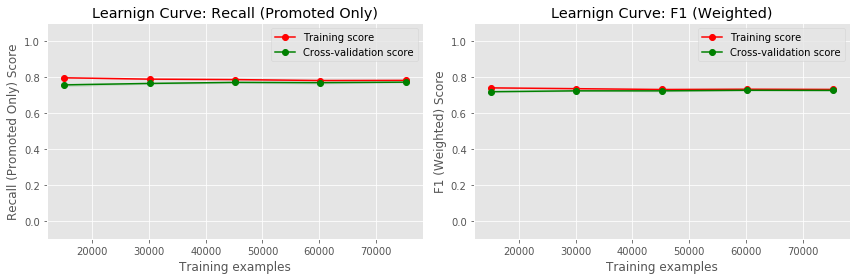

In [43]:
plot_learning_curves(estimator=piped_object
                     ,X=X,y=y
                     ,scoring=scoring
                     ,cv=cv_object
                     ,n_jobs=-1
                     ,verbose=0
                    )
plt.tight_layout()

**Observation:**

* Similar to the learning curves from the logistic regression model, we see that the training and test metrics converge towards each other even for a much smaller training size of only ~15,000 observations
* At ~75,000 observations in the training set, there is virtually no difference in the metrics between the train and the cross-validation set. 

**Conclusion:** The model we have created will generalize well to unknown observations and can be used in the future to predict (with similar precision and recall) employee promotability. 


[Back to Table of Contents](#TOC)

# <font color=maroon>Model Comparison</font><a class="anchor" id="Section5"></a>

### <i>Logistic Regression</i><a class="anchor" id="SVM_Metrics"></a>

From our analysis above, we see that the logistic regression model gives a recall score (for the promoted class) of 0.76 and a weighted F1 score of 0.74. Both these values are close to our original target of 0.75. The final model also gave a similar score on the test set and hence was able to generalize well without overfitting. Hyperparameter tuning for the regularization parameter was also quick. Six iterations on C using grid search (parallelized using 6 of 32 available cores**) ran in 6 minutes. Since all these models were developed in parallel, we can reasonably assume that each model took an average of 6 minutes to train on one core each. The fact that there were not many hyperparameters to tune meant that we could arrive at the final model rather quickly.

### <i>Support Vector Machine</i><a class="anchor" id="SVM_Metrics"></a>

We also see that the support vector machine (SVM) model gives a recall score (for the promoted class) of 0.78 and a weighted F1 score of 0.73. Again, both of these are close to our original target of 0.75. The final model also gave a similar score on the test set and hence was able to generalize well without overfitting. We used stochastic gradient descent (SGD) for the logistic regression model and the run time was extremely fast compared to previous logistic regression run time. Seven iterations on C using Grid Search (parallelized using 7 of 32 available cores**) ran in 30 seconds. We can reasonably assume that each model took on average 30 seconds to train on 1 core each. 

### <i> Comparative Analysis</i><br>
Since both models yielded similar and reasonable accuracy, and SVM took less time to train compared to the logistic regression model, one might be quick to jump to the conclusion that the SVM model is better. However this would be misleading since the nuances in creating the model have been overlooked. Looking deeper into the analysis (refer to the appendix for various model comparisons), we see that we initially started developing the SVM model using an implementation based on the libsvm library (sklearn.svm.SVC). We found that this this library was extremely slow to train the model with some variants of the model taking as long as 300 minutes to run on the 32 core machine. More importantly, **none of the algorithms converged** even when the maximum number of iterations were increased to a large value of 10,000. This was true whether we use the linear SVM, RBF Kernel or the Poly Kernel. Due to these limitations, eventually we had to switch to an SGD based approach to train the SVM model.

Secondly, an SVM model offers many more hyperparameters compared to the logistic regression model. In our analysis, we limited the grid search to one hyperparameter at a time. However to get the most optimal model, we may have to consider many hyperparameters at a time. For example, if we permute over just the hyperparameters C (6 values), kernel (3 values), gamma (6 values), and possibly maximum iterations (6 values), we will have to build over 600 models to get the final results. Although the training the logistic regression model was slower in this case, we knew that we had come up with an optimum model. To do the same with SVM, we would have to run many more hyperparameter combinations and this would lead to a higher overall training time compared to the logistic regression model. 

Thirdly, we could have used SGD on the logistic regression model as well. In fact, we tried this out (see appendix) and the training time reduced from 6 minutes to 1.5 minutes. Hence, the method used to train our models (as opposed to the algorithm itself) was responsible for the speed gains between our SVM and logistic regression.

The above analysis now might make one think that logistic regression is better than SVM. This however could again be misleading. For example, highly non-linear problem spaces may be inaccurately captured by logistic regression models without domain specific feature engineering. Even so, it may still not yield reasonable accuracy rates. In these specific cases, SVM with kernels can offer a better alternative since they can better capture these non-linearities without the explicit need for feature engineering. Of course, this comes at the expense of higher training times, but if reasonable accuracy is needed that might be our only option between these 2 types of models (logistic vs. SVM). 

### <i>Model Comparison Conclusion</i><br>

In conclusion, the model choice is problem specific. For large datasets (like the one we have), SGD was needed to train the models in a reasonable time. Linear SVM with SGD was a little faster than logistic regression and gave similar accuracy and hence would be the choice for our final model for this problem. 

** Note that the models were run on a 32-core machine, but each hyperparameter combination of the grid search can only be run on 1 core at a time. Hence, if we have 6 hyperparameter combinations in the grid search, the computer will only use 6 of the 32 available cores. 

[Back to Table of Contents](#TOC)

# <font color=maroon>Weights from Logistic Regression</font><a class="anchor" id="Section6"></a>

Now we will take the final model for logistic regression and try to interpret the weights for the model. 

There are many features being used in this logistic regression analysis, so listing the influence of each feature and its sub-levels is extremely redundant and deters from the purpose of this analysis which is to find and capitalize on the features that most dictate an employee’s promotability.

Since we standardized the features prior to building the model, all weights would be on the same scale. Hence, comparing the absolute values of the weights would provide information on which features are most important in obtaining a promotion. Larger absolute value of weights would imply greater variable importance. In addition, features were subdivided into their respective themes, and points of discussion revolve around the top outstanding features within each theme.

**Note:** While it might be tempting to infer causality from the weights, we should be careful not to do so. The data is observational (not collected through a randomized experiment). Moreover, there are several features that are correlated with each other. Hence, the weights corresponding to correlated features will be impacted by each other. We will continue with the evaluation of the weights keeping this important point in mind.

In [44]:
cv_object = StratifiedShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2,
                         random_state = 101      
                        )
scl_obj = StandardScaler()
weights = []
for train_indices, test_indices in cv_object.split(X,y): 
    # use this instead
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    scl_obj.fit(X_train)
    X_train_scaled = scl_obj.transform(X_train) # apply to training
    X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)
    
    lr_clf = LogisticRegression(C=0.1 
                            ,penalty='l2'
                            ,class_weight='balanced'
                            ,solver='liblinear'
                            ,n_jobs=-1
                            ,max_iter=1000
                            ,random_state=101
                            ,verbose=0
                           )

    with time_usage(" Logistic Regression with Scaled Inputs"):
        lr_clf.fit(X_train_scaled,y_train)  # train object
        
    weights.append(lr_clf.coef_[0])
    



C:\Users\mmoro\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 32.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
INFO:root: Logistic Regression with Scaled Inputs: Time Taken (seconds): 73.8169999123
C:\Users\mmoro\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 32.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
INFO:root: Logistic Regression with Scaled Inputs: Time Taken (seconds): 72.7792575359
C:\Users\mmoro\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 32.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
INFO:root: Logistic Regression with S

In [47]:
df_imputed.columns
weights_df = pd.DataFrame(weights,columns=df_imputed.columns)
weights_mean = np.mean(weights_df,axis=0)
weights_mean = pd.DataFrame(weights_mean,columns=['weight'])


In [48]:
# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train)

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)


#### Setting up the variables for displaying the weights and Support Vectors by Theme

In [49]:
# from dummies to original variables
accountability_matrix_label_last = []
company_code_last = []
functional_area_last = []
gjs_code_label_last = []
gjs_framework_last = []
job_family_label_last = []
operational_rollup_label_last = []
site_country_code_last = []
site_country_region_last = []
site_country_segment_last = []
certificate_order_grp_last = []

#sorted_weights = weights_mean.sort_values()

for each in df_imputed:
    if (each.find('accountability_matrix_label_last', 0, len(each)) == 0):
        accountability_matrix_label_last.append(each)
    elif (each.find('company_code_last', 0, len(each)) == 0):
        company_code_last.append(each)
    elif (each.find('functional_area_last', 0, len(each)) == 0):
        functional_area_last.append(each)
    elif (each.find('gjs_code_label_last', 0, len(each)) == 0):
        gjs_code_label_last.append(each)
    elif (each.find('gjs_framework_last', 0, len(each)) == 0):
        gjs_framework_last.append(each)
    elif (each.find('job_family_label_last', 0, len(each)) == 0):
        job_family_label_last.append(each)
    elif (each.find('operational_rollup_label_last', 0, len(each)) == 0):
        operational_rollup_label_last.append(each)
    elif (each.find('site_country_code_last', 0, len(each)) == 0):
        site_country_code_last.append(each)
    elif (each.find('site_country_region_last', 0, len(each)) == 0):
        site_country_region_last.append(each)
    elif (each.find('site_country_segment_last', 0, len(each)) == 0):
        site_country_segment_last.append(each)
    elif (each.find('certificate_order_grp_last', 0, len(each)) == 0):
        certificate_order_grp_last.append(each)

Now we will look at the  weights from the logistic regression in tabular format. Although the categorical variables were converted to dummy variables, we will roll up the dummy variables back to their original variable names.

In [50]:
def get_weights(theme,weights,top=15):
        
    weights_filt = weights[[i in theme for i in weights.index]]
    if(top>0):
        weights_filt=weights_filt.iloc[weights_filt['weight'].abs().argsort()][0:top]
    
    return(weights_filt.sort_values('weight'))


  
#### Definining features by theme

In [51]:
# Theme 1
rating_related = ['ppa_rating_last', 'comparatio_last'
                  ,'awards_points_cnt_sum_last','awards_points_sum_last'
                  ,'awards_bonus_cnt_sum_last','awards_bonus_sum_last'
                  ,'awards_peer_cnt_sum_last','months_since_promotion_max','months_since_promotion_last'
                 ,'movement_lateral_cnt_sum_last','transfer_event_cnt_sum_last','movement_demote_event_cnt_sum_last'
                 ,'promotion_cnt']


In [52]:
# Theme 2
supervision_related = ['supervisor_Y_max','supervisor_Y_last','span_of_control_direct_last', 'span_of_control_total_last','spv_ppa_rating']

In [53]:
# Theme 3
region_related = site_country_region_last+site_country_segment_last + site_country_code_last+ [
    'site_country_region_nunique','site_country_segment_nunique','site_country_code_nunique','site_desc_nunique'
    ,'site_city_code_nunique']

In [54]:
# Theme 4
manager_related = ['mgr_01_nunique','mgr_02_nunique','mgr_03_nunique','mgr_04_nunique'
                          ,'mgr_05_nunique','mgr_06_nunique','mgr_07_nunique','mgr_08_nunique'
                          ,'mgr_09_nunique','mgr_10_nunique','mgr_11_nunique','mgr_12_nunique'
                          ,'supervisor_nunique','changed_spv_cnt_sum_last'
                         ,'reporting_level_last','supervisor_nunique']

In [55]:
# Theme 5
func_area_related =  company_code_last + functional_area_last + operational_rollup_label_last +  accountability_matrix_label_last \
        + ['accountability_matrix_label_nunique','cost_center_code_nunique','operational_rollup_label_nunique'
          ,'org_unit_desc_nunique']
                                                                          

In [56]:
# Theme 6
job_grade_related = gjs_framework_last + gjs_code_label_last + job_family_label_last \
+ ['gjs_framework_nunique','gjs_sort_order_last'+'job_family_label_nunique']

In [57]:
# Theme 7
tenure_related = ['tenure_in_months_last','hiredAfter200901_max']

In [58]:
# Theme 8
education_related = certificate_order_grp_last + ['school_tier_last']

###  <font color=blue>Theme 1 - Performance </font> <a class="anchor" id="LRM_T1"></a>


In [59]:
w=get_weights(rating_related,weights_mean)
w

,weight
months_since_promotion_last,-0.390438
awards_points_cnt_sum_last,-0.107562
movement_lateral_cnt_sum_last,-0.076341
awards_peer_cnt_sum_last,-0.038641
movement_demote_event_cnt_sum_last,-0.006073
promotion_cnt,0.040231
awards_points_sum_last,0.040365
awards_bonus_sum_last,0.072125
comparatio_last,0.081791
awards_bonus_cnt_sum_last,0.166269


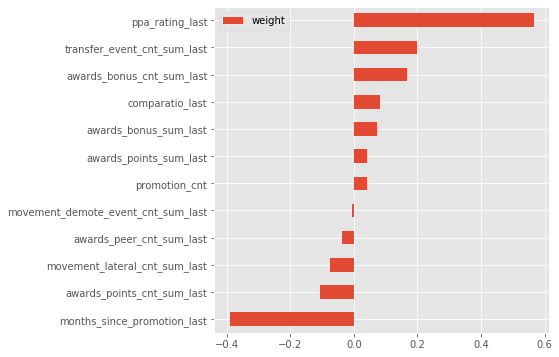

In [60]:
w.plot(kind='barh', figsize = (6,6))

**Observations:**
* The three highest features under the performance theme by scalar weight are ppa_rating_last, months_since_promotion_last, and transfer_event_cnt_sum_last.
* Of the three, ppa_rating_last has the largest weight and stands as one of the largest weights within our logistic model. Realistically, this makes sense – an employee’s performance rating likely has a large influence on their promotability, validated by these weights. 
* Likewise, the negative influence of months_since_promotion_last also reflects stagnating in one’s career. 
* Meanwhile, transfer_event_cnt_sum_last has a mild positive influence. Logically, this makes sense as the longer an employee remains in one job, the less likely that employee will see vertical movement. 

###  <font color=blue>Theme 2 - Supervision Status </font> <a class="anchor" id="LRM_T2"></a>


In [61]:
w=get_weights(supervision_related,weights_mean)
w

,weight
span_of_control_direct_last,0.031379
supervisor_Y_max,0.071703
span_of_control_total_last,0.071963
supervisor_Y_last,0.347564


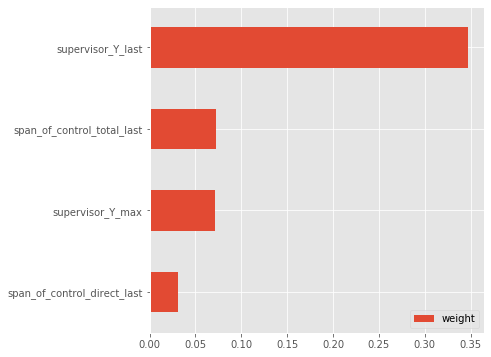

In [62]:
w.plot(kind='barh', figsize = (6,6))

**Observations:**
* Although there are not many features that fall under this theme, it appears that of all the features, the most influential is whether or not an employee held supervisory status.

###  <font color=blue>Theme 3 - Regional </font><a class="anchor" id="LRM_T3"></a>


In [63]:
w=get_weights(region_related,weights_mean)
w

,weight
site_country_segment_last_Israel,-0.022872
site_country_code_last_AU,-0.022519
site_country_code_last_PR,-0.019365
site_country_code_last_CN,-0.018002
site_country_code_last_CA,-0.017659
site_country_code_last_HU,-0.011072
site_country_code_last_IE,-0.006908
site_country_code_last_ES,-0.006689
site_country_code_last_IN,0.001052
site_country_code_last_BE,0.002891


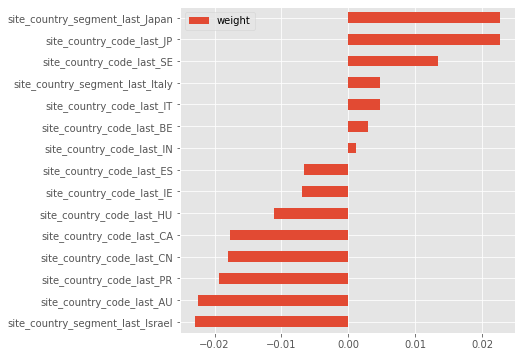

In [64]:
w.plot(kind='barh', figsize = (6,6))

**Observations:**
* All the weights for these categories are very small (less than +/-0.025), hence they don't seem to have an  impact on the prediction of promotion.


###  <font color=blue>Theme 4 - Manager</font> <a class="anchor" id="LRM_T4"></a>

In [65]:
w=get_weights(manager_related,weights_mean)
w

,weight
changed_spv_cnt_sum_last,-0.353031
mgr_09_nunique,-0.213969
mgr_03_nunique,-0.177033
mgr_04_nunique,-0.166260
reporting_level_last,-0.119984
mgr_12_nunique,-0.069654
mgr_08_nunique,-0.043112
mgr_06_nunique,-0.036752
mgr_01_nunique,0.000924
mgr_10_nunique,0.069613


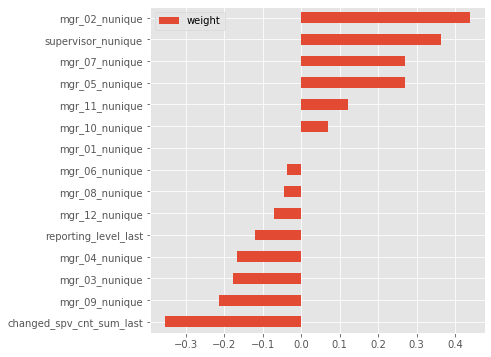

In [66]:
w.plot(kind='barh', figsize = (6,6))

**Observations:**
* The weights for the variables in the supervisor theme have a much higher value than other themes, so these are more inflencial in the prediction of promotion. 
* Interestingly, it does not appear as though an employee's direct manager count holds much positive influence over his/her promotability, rather mgr_02_nunique has the strongest weight under this theme.
* It is noticeable that some manager levels have positive weights, while others have negative weights. There is no logical reason for this behavior. We know from the exploratory analysis that these variables were highly correlated, and because of multicollinearity the weights for these variables can be influenced by each other. Hence, we cannot conclude any causation based on these weights alone.
* The number of supervisors also has a moderate influence on promotability (supervisor_nunique), as does the changed_spv_cnt_sum_last. 

###  <font color=blue> Theme 5 - Functional Area </font> <a class="anchor" id="LRM_T5"></a>


In [67]:
w=get_weights(func_area_related,weights_mean)
w

,weight
accountability_matrix_label_last_Noor,-0.001967
company_code_last_Connelly,-0.001157
company_code_last_Odfield,-0.001009
operational_rollup_label_last_CashtownMcKnightstown,-0.000962
company_code_last_Engaged,-0.000692
accountability_matrix_label_last_Leanamanu,-0.000242
operational_rollup_label_last_Rutherwood,-0.000078
accountability_matrix_label_last_Kimmell,-0.000057
company_code_last_Dannevirke,0.000955
operational_rollup_label_last_Smithfields,0.000993


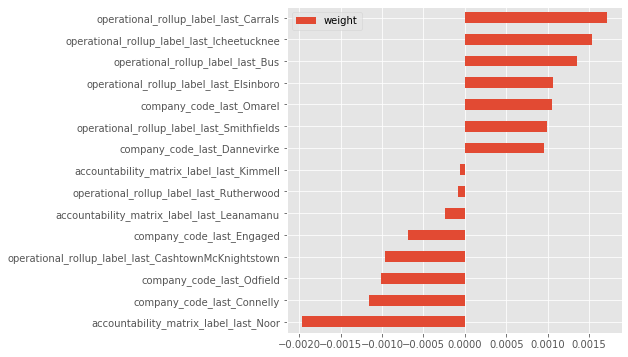

In [68]:
w.plot(kind='barh', figsize = (6,6))

**Observations:**
* All the weights for these categories are very small (less than +/-0.002), hence they don't seem to have an  impact on the prediction of promotion.

###  <font color=blue> Theme 6 - Job Grade </font> <a class="anchor" id="LRM_T6"></a>


In [69]:
w=get_weights(job_grade_related,weights_mean)
w

,weight
job_family_label_last_Wadford,-0.001727
job_family_label_last_Asnaki,-0.001599
job_family_label_last_Comite,-0.001064
job_family_label_last_Ganado,-0.000888
job_family_label_last_Deralls,-0.000734
job_family_label_last_Wary,-0.000494
job_family_label_last_Sandbar,-0.000487
job_family_label_last_Prettyland,-0.000158
job_family_label_last_Labo,-0.000119
gjs_code_label_last_S1,0.000041


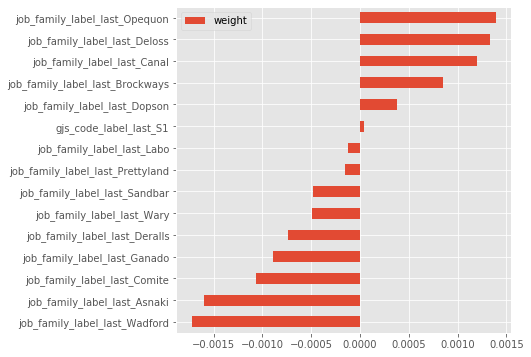

In [70]:
w.plot(kind='barh', figsize = (6,6))

**Observations:**
* All the weights for these categories are very small (less than +/-0.002), hence they don't seem to have an  impact on the prediction of promotion.


###  <font color=blue>Theme 7 - Tenure </font> <a class="anchor" id="LRM_T7"></a>


In [95]:
w=get_weights(tenure_related,weights_mean)
w

,weight
tenure_in_months_last,-0.284379
hiredAfter200901_max,0.114393


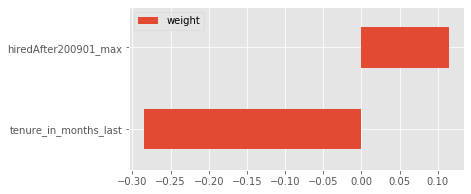

In [97]:
w.plot(kind='barh', figsize = (6,3))

**Observations:**
* Interestingly, an employee’s hire date after 2009 appears to have some mild positive influence (0.10) on promotability, though this conflicts with a tenure_in_months_last which has a heavier negative weight. The model predicts more promotability for people after hired after 2009. While this may point to  age-based discrimination, as explained earlier, we should be careful not to derive causation from these results.

###  <font color=blue>Theme 8 - Education </font> <a class="anchor" id="LRM_T8"></a>


In [73]:
w=get_weights(education_related,weights_mean)
w

,weight
certificate_order_grp_last_11-Pre-University,-0.112103
certificate_order_grp_last_12-Technical Certificates,-0.111492
certificate_order_grp_last_13-Secondary,-0.102019
certificate_order_grp_last_99-Not Indicated,-0.098354
certificate_order_grp_last_08-Bachelor Level Degree,-0.086192
certificate_order_grp_last_10-Diploma,-0.065430
certificate_order_grp_last_02-Master Level Degree,-0.050354
certificate_order_grp_last_09-Associate Degree - Advanced Diploma - Specialist Diploma,-0.024028
certificate_order_grp_last_14-Primary,-0.015363
certificate_order_grp_last_04-Bachelor Level Degree - First Class,-0.003889


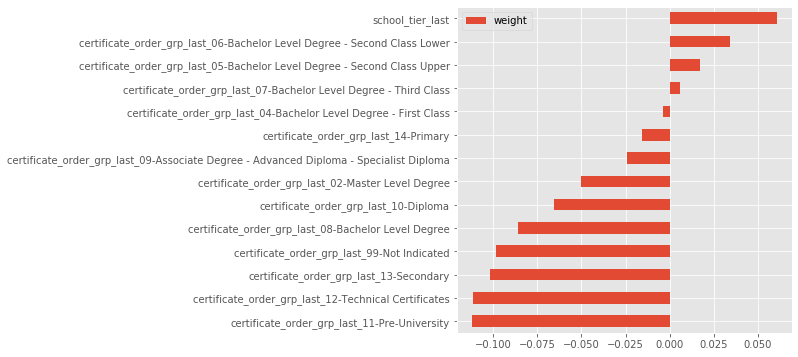

In [74]:
w.plot(kind='barh', figsize = (6,6))

**Observations:**
* The top education sub-features all have mild negative correlation with promotability, but they are also the lower educational achievements. 
* This does not raise concern as higher education may have minimal impact (may be proportional to experience/tenure) while lower education is typically associated with a plateaued career.  
* We know from the exploratory analysis that these variables were highly correlated, and because of multicollinearity the weights for these variables can be influenced by each other. Hence, we cannot conclude any causation based on these weights alone.



[Back to Table of Contents](#TOC)


# <font color=maroon>Interpreting Support Vectors</font><a class="anchor" id="Section7"></a>

We cannot get the support vectors from the SVM model built using stochastic gradient descent. In order to analyze the support vectors, we need to rebuild the model using the non-stochastic gradient descent method. We tried several models (see appendix), and the model that produced the best trade-offs between the metrics was used poly kernel with C = 100 and max-iters = 10,000.
We will use the same model to evaluate the support vectors going forward.

In [75]:
svm_clf = SVC(C=100 
              ,kernel='poly'
              ,degree=3
              ,gamma='auto'
              ,class_weight='balanced'
              ,verbose=True
              ,max_iter=10000
              ,random_state=101
             ) # get object
 
piped_object = Pipeline([('scale', std_scl),  # do this
                         ('svm_model', svm_clf)]) # and then do this

svm_clf.fit(X_train_scaled, y_train)  # train object


[LibSVM]

C:\Users\mmoro\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
    max_iter=10000, probability=False, random_state=101, shrinking=True,
    tol=0.001, verbose=True)

In [76]:
df_tested_on = df_imputed.iloc[train_indices] # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:]

df_support.loc[:,'promotion_max'] = y[svm_clf.support_] 

df_imputed.loc[:,'promotion_max'] = y 
df_support.info()



C:\Users\mmoro\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\mmoro\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


<class 'pandas.core.frame.DataFrame'>
Int64Index: 13545 entries, 16738 to 37827
Columns: 592 entries, promotion_cnt to promotion_max
dtypes: float64(8), int64(44), uint8(540)
memory usage: 12.5 MB


In [77]:
# group the original data and the support vectors
df_grouped_support = df_support.groupby(['promotion_max'])
df_grouped = df_imputed.groupby(['promotion_max'])


In [79]:
#setting vars for all  the plots
top=2
verbose=0
hist=1

**Methodology:**
* We decided to use histograms instead of density plots to analyze the data because these can give a clearer picture of the model behavior.
* Since we have an abundant number of variables, we decided to display the top two that have the biggest difference between the original and the support vectors based on mean values.
* The support vectors are usually created around points that are close to each other in the multi-dimensional feature space, but belong to different classes. By comparing the distribution of the original dataset and the support vectors, we can get a clear picture of which variables were most influential in distinguishing between classes. Variables in which the support vectors are showing a closer distribution between classes than the original dataset are more influential in the classification. This is what we are looking for in the subsequent analysis.

###  <font color=blue>Theme 1 - Performance </font> <a class="anchor" id="SVM_T1"></a>

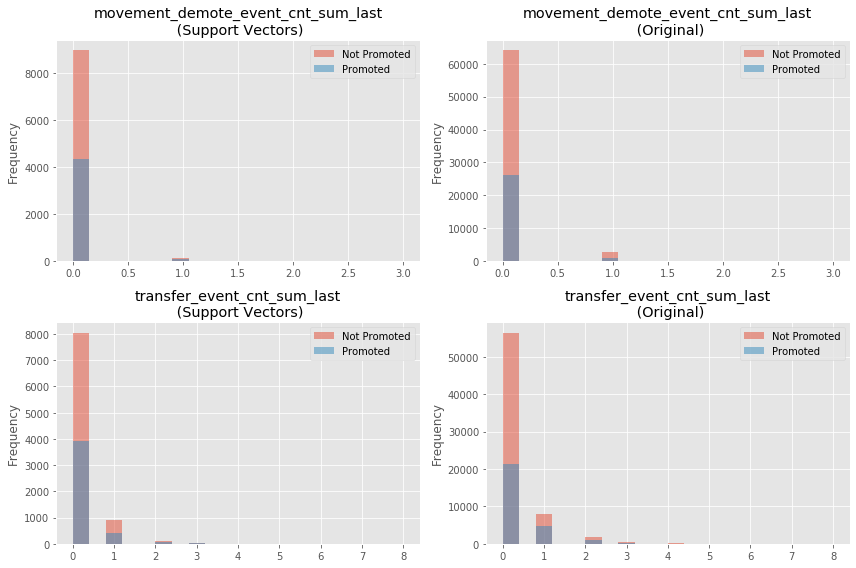

In [80]:
plot_sv(rating_related,top=top,verbose=verbose,hist=hist)
plt.tight_layout()

**Observations:**
* Demotion variable: The proportion of employees who got promoted vs. did not get promoted is higher for the support vector by a small amount compared to the original dataset. This variable has a minor impact on the classification. 
* Transfer variable: This variable has similar behavior as the "demotion" variable.

###  <font color=blue>Theme 2 - Supervision Status </font> <a class="anchor" id="SVM_T2"></a>

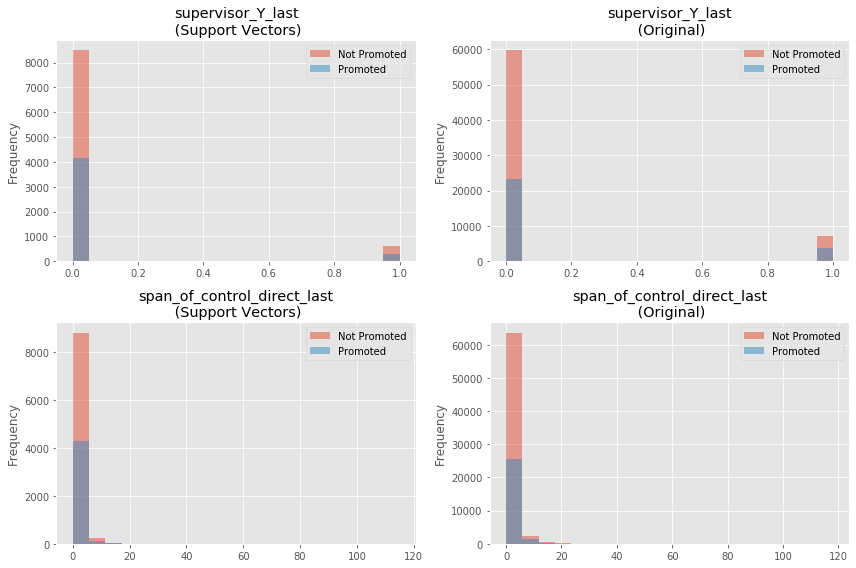

In [81]:
plot_sv(supervision_related,top=top,verbose=verbose,hist=hist)
plt.tight_layout()

**Observations:**
* Supervisor variable: The proportion of employees who got promoted vs. did not get promoted is higher for the support vector by a small amount compared to the original dataset. This variable had a minor impact on the classification. 
* Span of control variable: This variable has similar behavior as the "supervisor" variable.

###  <font color=blue>Theme 3 - Regional </font><a class="anchor" id="SVM_T3"></a>

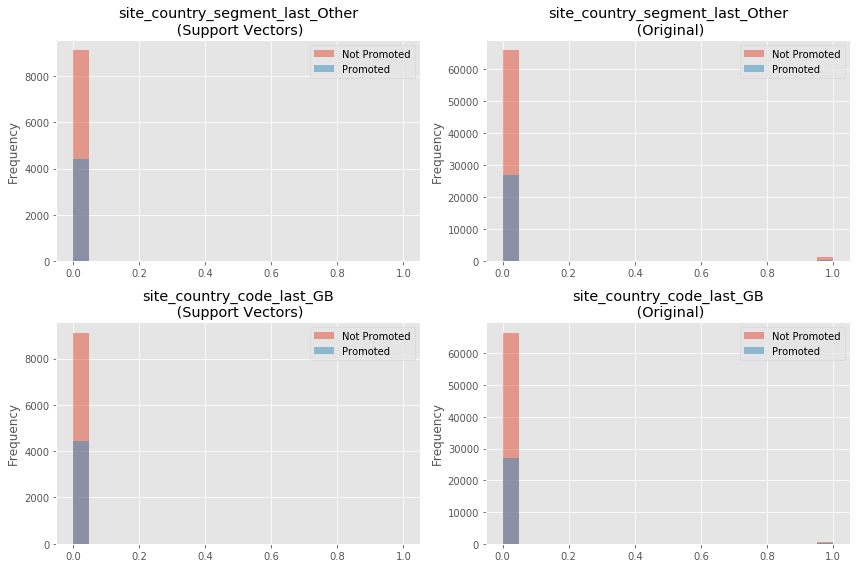

In [82]:
plot_sv(region_related,top=top,verbose=verbose,hist=hist)
plt.tight_layout()

**Observations:**
* Site country segment variable: The proportion of employees who got promoted vs. did not get promoted is higher for the support vector by a small amount compared to the original dataset. Hence this variable had a minor impact on the classification. 
* Site country code variable: This variable has similar behavior as the "Site Country Segment" variable.

###  <font color=blue>Theme 4 - Manager</font> <a class="anchor" id="SVM_T4"></a>

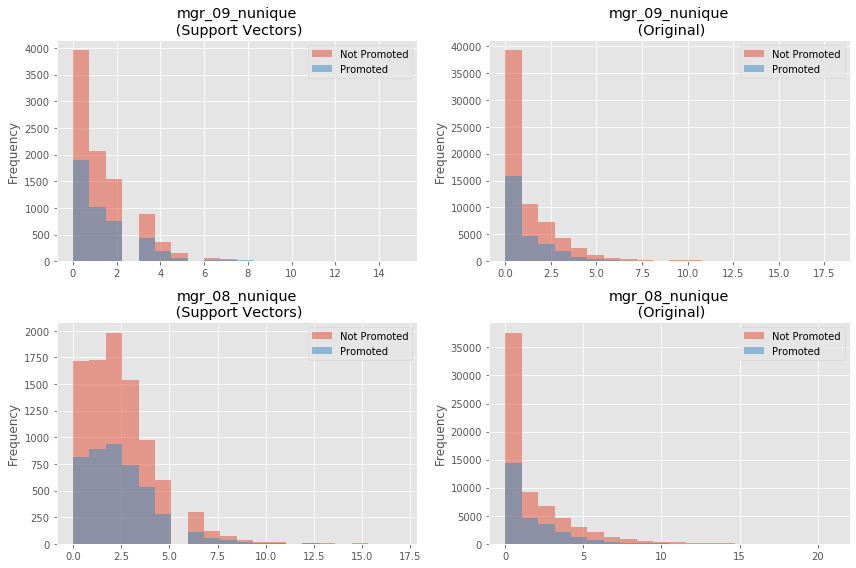

In [83]:
plot_sv(manager_related,top=top,verbose=verbose,hist=hist)
plt.tight_layout()

**Observations:**
* Manager level 9 variable:  The shape of the distribution curve in the support vector is substantially different from the original dataset. It has a shorter tail and a closer distribution between those who got promoted and those who did not get promoted. This shows that this variable is more influential on the prediction of the promotion events.
* Manager level 8 variable: The shape of the distribution curve in the support vector is also drastically different from the original dataset. Employees with only one manager 8 have a much higher proportion in the original dataset (spike observed at manager level 8 equal to 1) compared to the support vector, implying that these employees were easier to separate between the two class levels. On the other hand, employees with more than one manager level 8, were harder to separate, hence they are showing up as higher proportion in the support vectors. 

###  <font color=blue> Theme 5 - Functional Area </font> <a class="anchor" id="SVM_T5"></a>

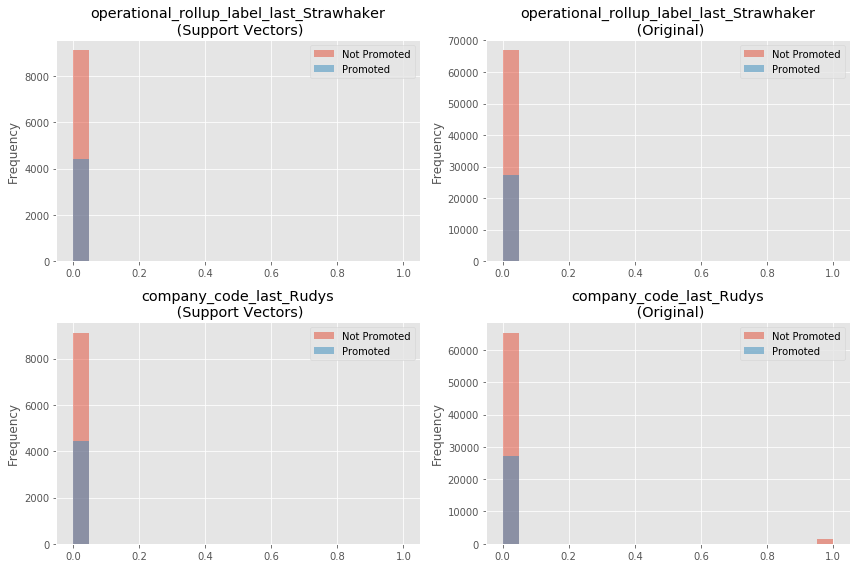

In [84]:
plot_sv(func_area_related,top=top,verbose=verbose,hist=hist)
plt.tight_layout()

**Observations:**
* Strawhaker operational rollup  variable: The proportion of employees who got promoted vs. did not get promoted is higher for the support vector by a small amount compared to the original dataset. Hence, this variable had a minor impact on the classification. 
* Rudys company code variable: This variable has similar behavior as the "strawhaker operational rollup" variable. Another interesting observation is that in the original dataset, those who belong to Rudy company were not promoted. Hence, it was easy to separate the class levels based on this variable and they don't show up in the support vectors.


###  <font color=blue> Theme 6 - Job Grade </font> <a class="anchor" id="SVM_T6"></a>

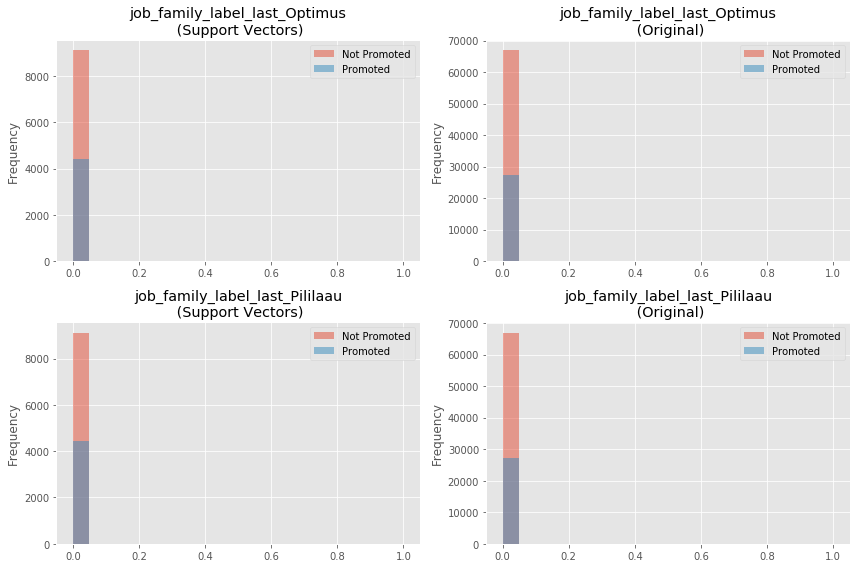

In [86]:
plot_sv(job_grade_related,top=top,verbose=verbose,hist=hist)
plt.tight_layout()

**Observations:**
* Optimus job family variable: The proportion of employees who got promoted vs. did not get promoted is higher for the support vector by a small amount compared to the original dataset. This variable had a minor impact on the classification. 
* Pililaau job family variable: This variable has similar behavior as the "optimus job family" variable.

###  <font color=blue>Theme 7 - Tenure </font> <a class="anchor" id="SVM_T7"></a>

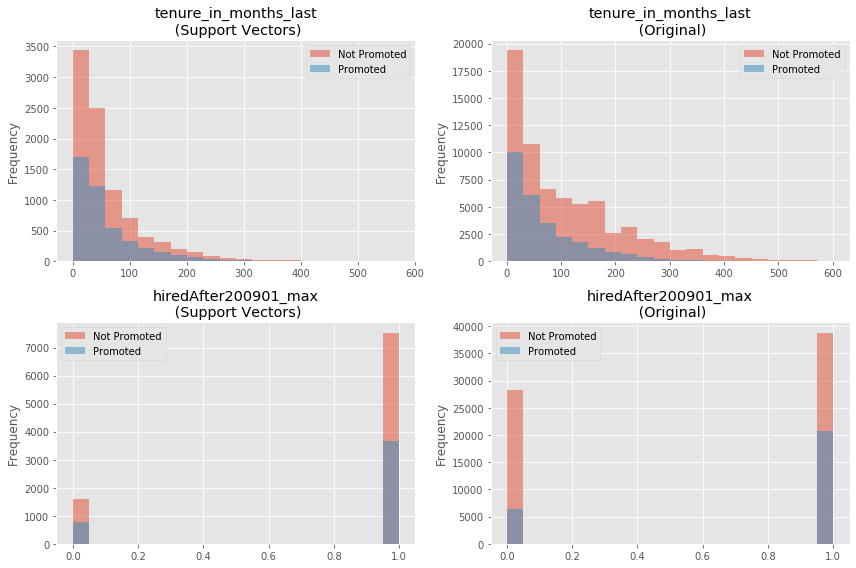

In [87]:
plot_sv(tenure_related,top=top,verbose=verbose,hist=hist)
plt.tight_layout()

**Observations:**
* Tenure in months variable: The shape of the distribution curve in the support vector is substantially different from the original dataset. It has a shorter tail and closer distribution between those who got promoted and those who did not get promoted. This shows that this variable is more influential on the prediction of the promotion events. Another interesting observation is that employees with a tenure of more than 300 months were not promoted. It was relatively easy to separate the class levels based on tenure greater than 300 months, and because of this, we don't have many employees with a tenure greater than 300 months in the support vectors.

* Hired after 2009 variable: For the employees hired after 2009, the proportion of promoted vs. not promoted is slightly (but not significantly) smaller for the support vector. More interestingly, some employees who were hired before 2009 were harder to classify in the right promotion class, hence the relative distribution between class levels is higher in the support vector compared to the original.

###  <font color=blue>Theme 8 - Education </font> <a class="anchor" id="SVM_T8"></a>

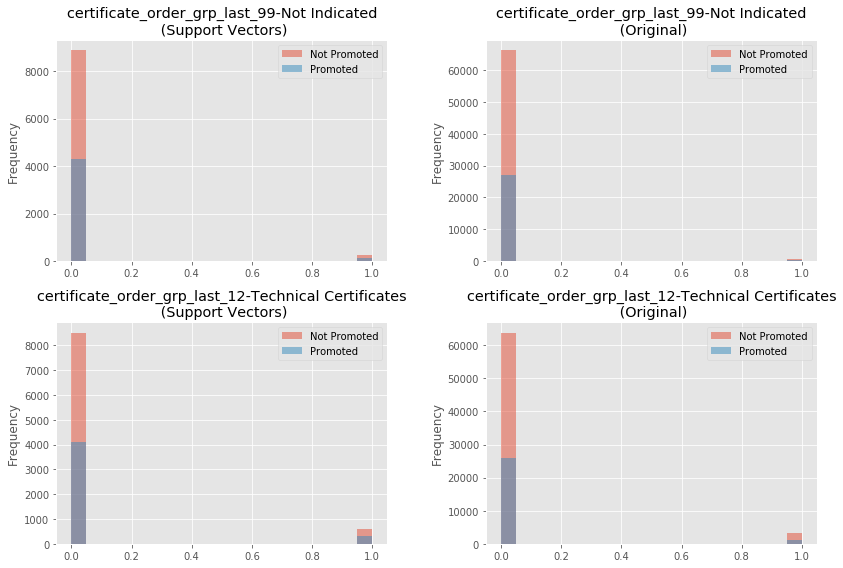

In [88]:
plot_sv(education_related,top=top,verbose=verbose,hist=hist)
plt.tight_layout()

**Observations:**
* Certificate not indicated variable: The proportion of employees who got promoted vs. did not get promoted is higher for the support vector by a small amount compared to the original dataset; hence, this variable had a minor impact on the classification. 
* Technical certificate variable: This variable has similar behavior as the "certificate not indicated" variable.

[Back to Table of Contents](#TOC)

# <font color=maroon>Conclusion</font><a class="anchor" id="Section8"></a>
Our objective for this analysis was to compare two classification models (logistic regression and SVM) to identify which model can best identify employees with promotion potential. The metrics for determining best performance are weighted F1 and recall as it is preferable to lean towards overidentifying promotable candidates for a larger promotable candidate pool than being too restrictive. Additionally, we seek to identify themes and features that are strong indicators of promotability (or strong evidence against promotability). 

Modeling can be a computationally and time intensive process; since this model will need to be rerun on a regular basis, it needs to be economical in the sense of time. With these considerations, we found that the models performed similarly, but the linear SVM with SGD was the best balance of accuracy and smallest training time. Based on the logistic regression model, we found that the outstanding themes are the "performance" and "manager" themes, particularly the PPA rating and supervisor flag features respectively, which have significant overall influence on promotability. 

Our next steps in support of this analysis are to use other classification techniques that include tree-based and KNN distance-based algorithms to improve the classification accuracy and coverage.

[Back to Table of Contents](#TOC)

# <font color=maroon>Appendix</font><a class="anchor" id="Section9"></a>

### <i>Model Comparison Table</i><a class="anchor" id="App_Table"></a><br>
We compared the models in a table to compare the results when we ran a full versus a subset of columns, settings, iterations.



| Metric                   | <b><font color = maroon>Logistic(1)</b></font>|Logistic (2) | Linear SVM (1) | <b><font color = maroon>Linear SVM (2) </b></font>| RBF SVM (1) | Poly SVM (1) | Poly SVM (1) |
|--------------------------|-------------|--------------|----------------|----------------|-------------|--------------|--------------|
| Method                   | <b><font color = maroon><b>Non SGD</b></font>     | SGD         | Non SGD        | <b><font color = maroon><b>SGD</b></font>            | Non SGD     | Non SGD      | Non SGD      |
| <b><font color = maroon>Recall (Promoted) </font> </b>        |<font color = maroon><b> 0.77</b>  </font>  | <font color = maroon><b>0.75 </b>  </font>       | <font color = maroon><b>0.71 </b>  </font>         | <font color = maroon><b>0.77</b>   </font>         | <font color = maroon><b>0.62  </b>  </font>     | <font color = maroon><b>0.79 </b> </font>        | <font color = maroon><b>0.62</b> </font>         |
| Recall (Weighted)        | <b><font color = maroon>0.73</b></font>       | 0.72       | 0.49           | <b><font color = maroon>0.7</b></font>            | 0.52       | 0.51        | 0.68         |
| Recall   (Global)        | <b><font color = maroon><b>0.73</font></b>        | 0.72         | 0.49           | <b><font color = maroon><b>0.7</font></b>            | 0.52        | 0.51         | 0.68         |
| Accuracy                 | <b><font color = maroon>0.73</b></font>| 0.72         | 0.49           | <b><font color = maroon><b>0.7</font></b>            | 0.52        | 0.51         | 0.68         |
| <b><font color = maroon>F1   (Weighted)</font></b>          | <b><font color = maroon>0.73</b></font>        | <b><font color = maroon>0.73</font></b>         | <b><font color = maroon>0.49</font></b>           | <b><font color = maroon>0.72</b></font>           | <b><font color = maroon>0.52</font></b>        | <b><font color = maroon>0.52</font></b>         | <b><font color = maroon>0.69</font></b>         |
| F1 (Global)              | <b><font color = maroon><b>0.73</font></b>        | 0.72         | 0.49           | <b><font color = maroon><b>0.72</font></b>           | 0.52        | 0.51         | 0.68         |
| Precision   (Weighted)   |<b><font color = maroon> 0.78 </font></b>       | 0.76         | 0.62           | <b><font color = maroon><b>0.77</font></b>           | 0.62        | 0.68         | 0.72         |
| Precision (Global)       | <b><font color = maroon>0.73</b></font>        | 0.72         | 0.49           | <b><font color = maroon><b>0.72</font></b>           | 0.52        | 0.51         | 0.68         |
| C /   Alpha (Best Model) | <b><font color = maroon><b>0.1</font></b>         | 0.01         | 10             | <b><font color = maroon><b>0.01</font></b>           | 1           | 100          | 1000         |
| max_iter (Best Model)    | <b><font color = maroon><b>-</font></b>           | 1000         | 100            | <b><font color = maroon><b><font color = maroon>1000</font></b>           | 5000        | 10000        | 10000        |
| Run   Time (mins)        | <b><font color = maroon>10.5</font></b>        | 2.5          | 12             | <b><font color = maroon>2</font></b>              | 180         | 300          | 300          |
| Cores                    | <b><font color = maroon><b>8 cores</font></b>     | 8 cores      | 1 core         |<b><font color = maroon> <b>8 cores</font></b>        | 15 cores    | 18 cores     | 18 cores     |
    
    
[Back to Table of Contents](#TOC)